In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter



In [2]:
# Ensure required nltk packages are downloaded
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load the dataset
df = pd.read_csv(r"E:\\twitter_training\\twitter_training.csv")

# Rename columns for easier access
df.rename(columns={'Positive': 'category', 'im getting on borderlands and i will murder you all ,': 'text'}, inplace=True)

# Display the first few rows of the dataframe
print(df.head())

   2401  Borderlands  category  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  


In [4]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing text data
df = df.dropna(subset=['text'])

# Define the mask for word cloud
mask = np.array(Image.open(r"E:\prodigy\archive (2)\twitter.png"))

2401             0
Borderlands      0
category         0
text           686
dtype: int64


In [8]:
# Clean the text data
def clean_text(text):
    if isinstance(text, str):
        # Skip BeautifulSoup processing if the text is very short or resembles a file path
        if len(text.strip()) < 5 and re.match(r"^[\s\.]+$", text):
            return text

        # Remove HTML tags
        text = BeautifulSoup(text, 'html.parser').get_text()

        # Remove special characters and digits
        text = re.sub(r"[^a-zA-Z]", " ", text)

        # Remove punctuation
        text = text.translate(str.maketrans("", "", string.punctuation))

        # Remove emojis
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        # Convert to lowercase
        text = text.lower()

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        return text
    else:
        return ""

# Apply the clean_text function to the DataFrame
df["text"] = df["text"].apply(clean_text)

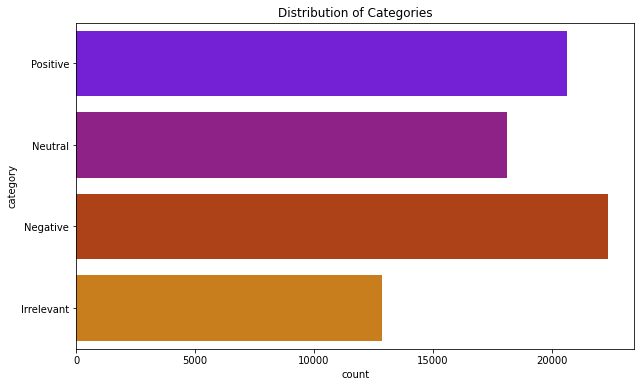

In [9]:

# Plot the distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(y="category", data=df, palette="gnuplot")
plt.title("Distribution of Categories")
plt.show()


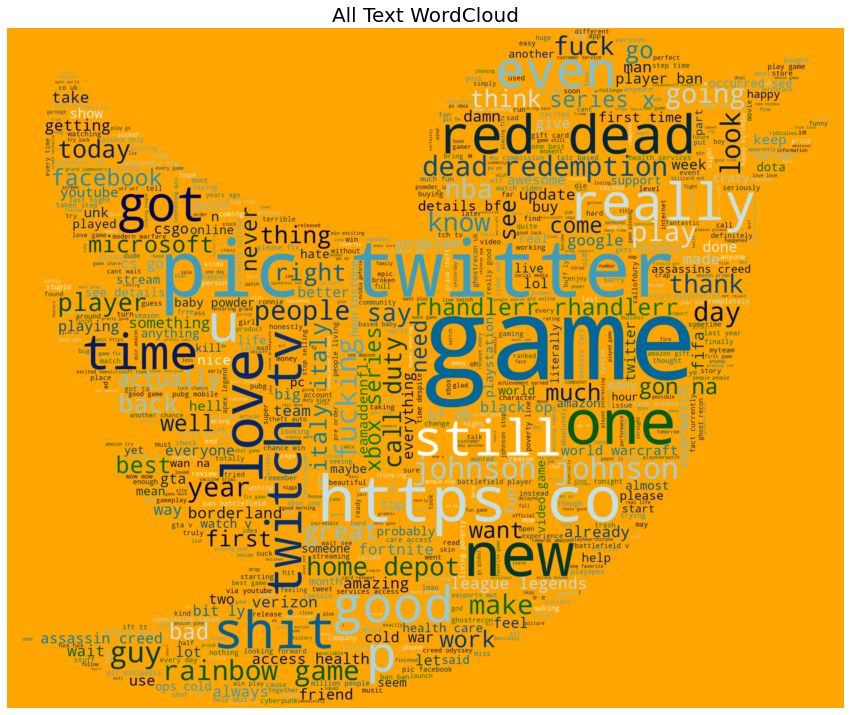

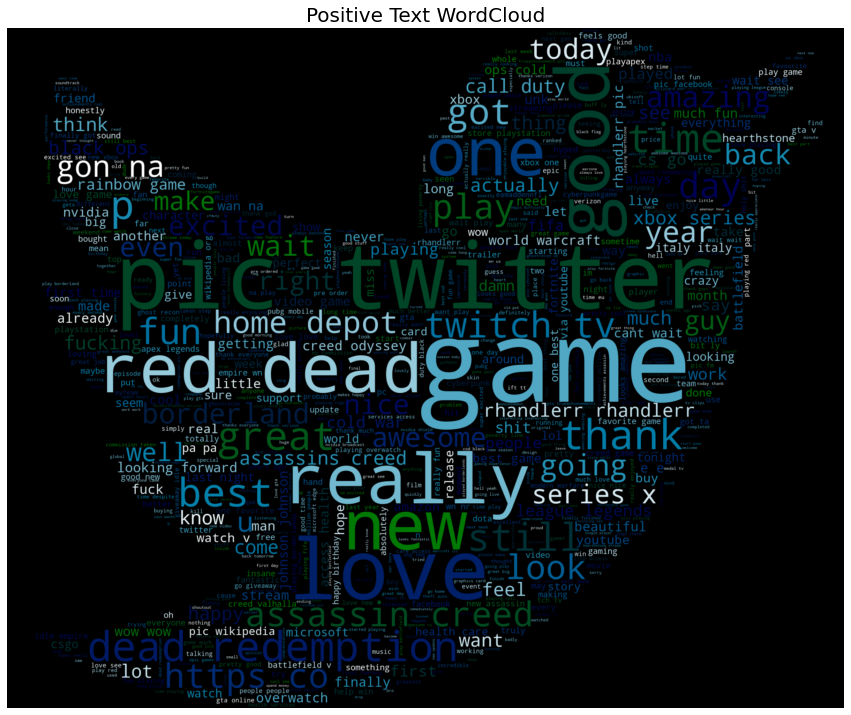

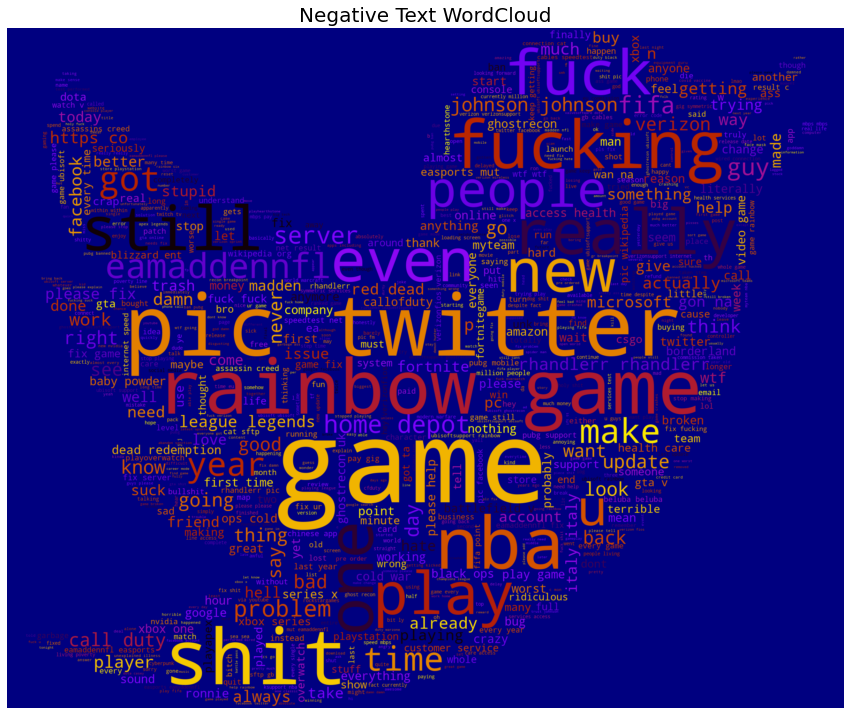

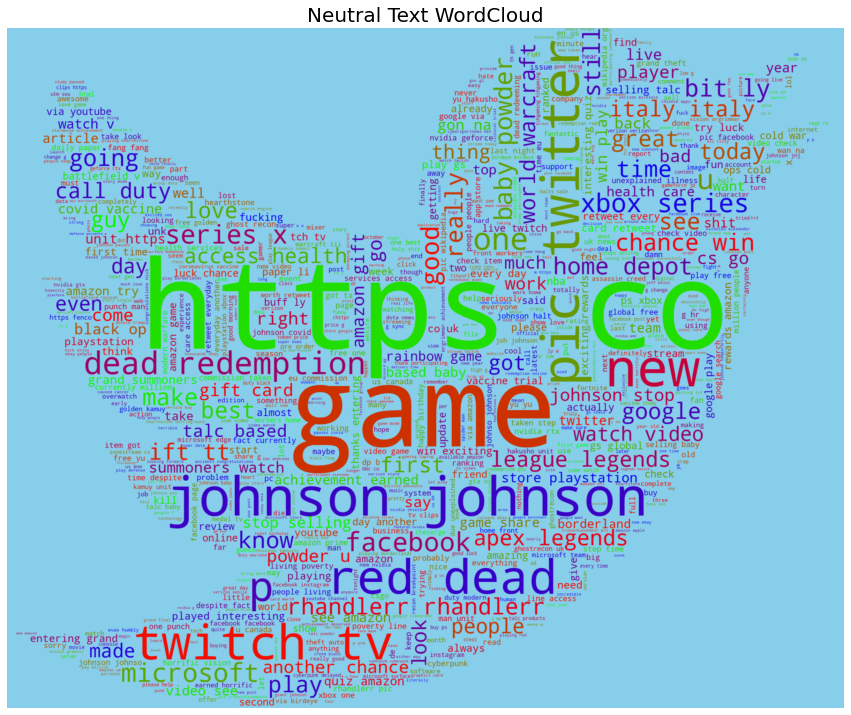

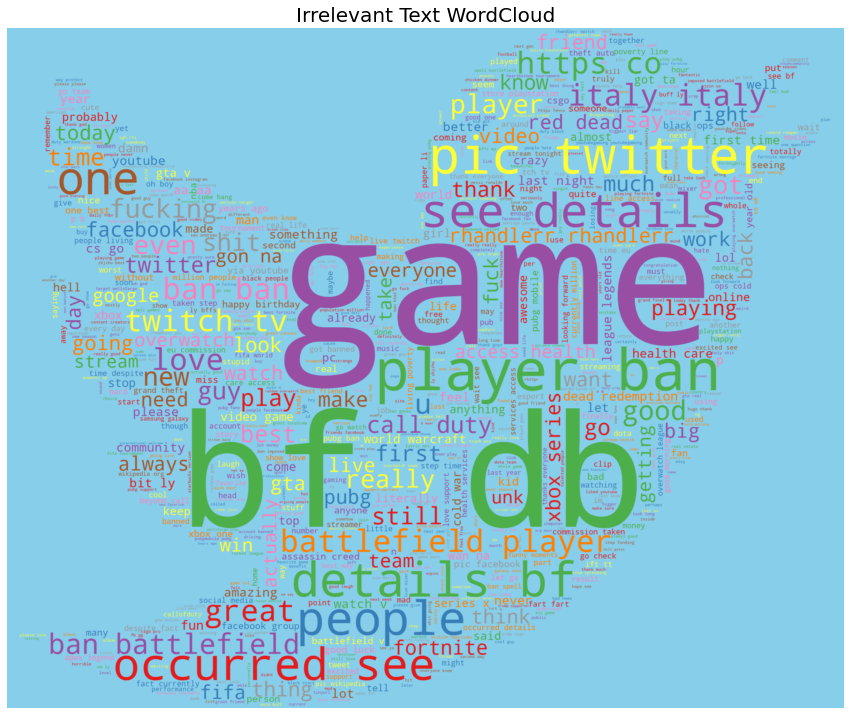

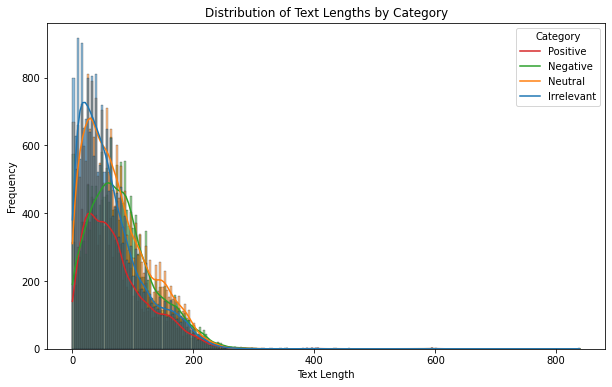

In [11]:
# Create word clouds for different sentiment categories
def create_wordcloud(text, title, bg_color, colormap):
    plt.figure(figsize=(15, 15))
    wordcloud = WordCloud(width=800, height=800, stopwords=STOPWORDS, background_color=bg_color, 
                          max_words=800, colormap=colormap, mask=mask).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()
# All text word cloud
all_text = " ".join(df['text'].values.tolist())
create_wordcloud(all_text, "All Text WordCloud", 'orange', 'ocean')

# Positive text word cloud
positive_text = " ".join(df[df["category"] == "Positive"]["text"])
create_wordcloud(positive_text, "Positive Text WordCloud", 'black', 'ocean')

# Negative text word cloud
negative_text = " ".join(df[df["category"] == "Negative"]["text"])
create_wordcloud(negative_text, "Negative Text WordCloud", 'navy', 'gnuplot')

# Neutral text word cloud
neutral_text = " ".join(df[df["category"] == "Neutral"]["text"])
create_wordcloud(neutral_text, "Neutral Text WordCloud", 'skyblue', 'brg')

# Irrelevant text word cloud
irrelevant_text = " ".join(df[df["category"] == "Irrelevant"]["text"])
create_wordcloud(irrelevant_text, "Irrelevant Text WordCloud", 'skyblue', 'Set1')

# Compare text lengths by category
p_len = df[df["category"] == "Positive"]["text"].str.len()
n_len = df[df["category"] == "Negative"]["text"].str.len()
neu_len = df[df["category"] == "Neutral"]["text"].str.len()
irr_len = df[df["category"] == "Irrelevant"]["text"].str.len()

lengths_df = pd.DataFrame({
    "Positive": p_len,
    "Negative": n_len,
    "Neutral": neu_len,
    "Irrelevant": irr_len
})

plt.figure(figsize=(10, 6))
sns.histplot(data=lengths_df, kde=True)
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Category', labels=['Positive', 'Negative', 'Neutral', 'Irrelevant'])
plt.show()


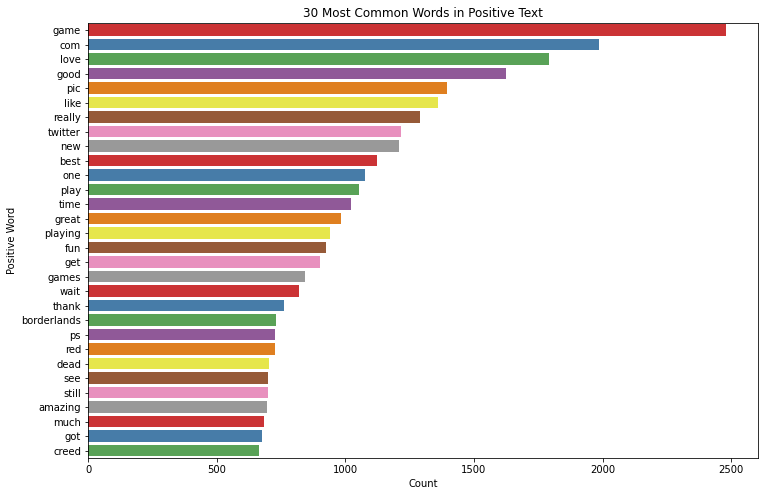

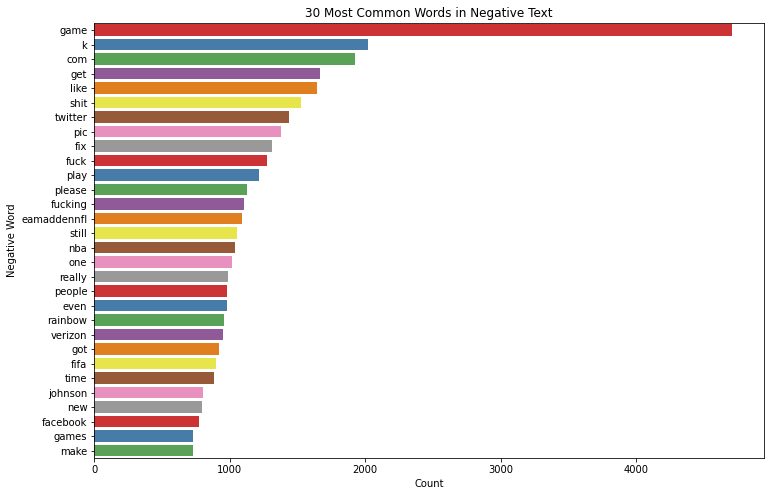

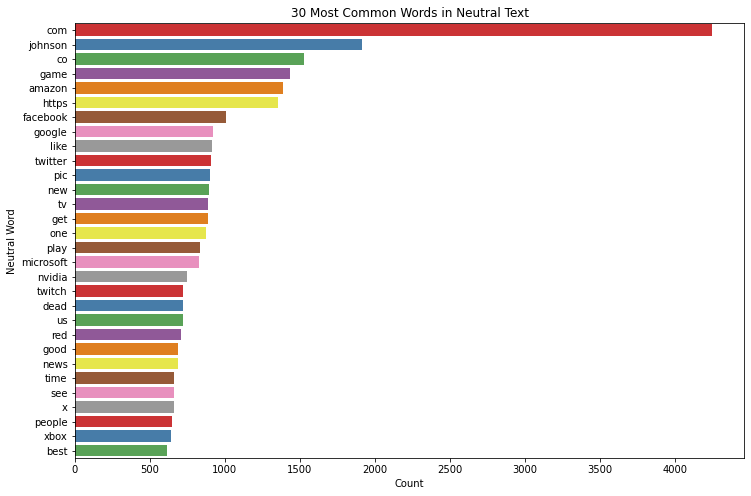

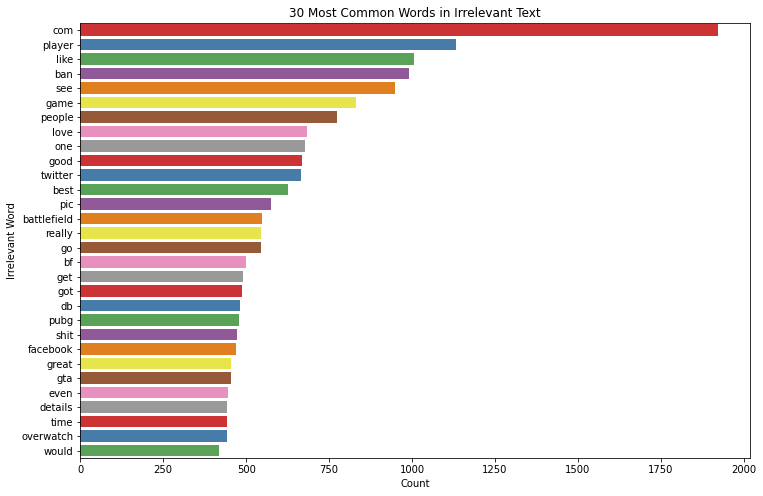

In [12]:
# Most common words in positive text
def plot_common_words(category):
    text = df[df["category"] == category]["text"]
    data_set = text.str.split()
    all_words = [word for sublist in data_set for word in sublist]
    counter = Counter(all_words)
    common_words = counter.most_common(30)
    df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Word', data=df_common_words, palette="Set1")
    plt.title(f'30 Most Common Words in {category} Text')
    plt.xlabel('Count')
    plt.ylabel(f'{category} Word')
    plt.show()

plot_common_words("Positive")
plot_common_words("Negative")
plot_common_words("Neutral")
plot_common_words("Irrelevant")


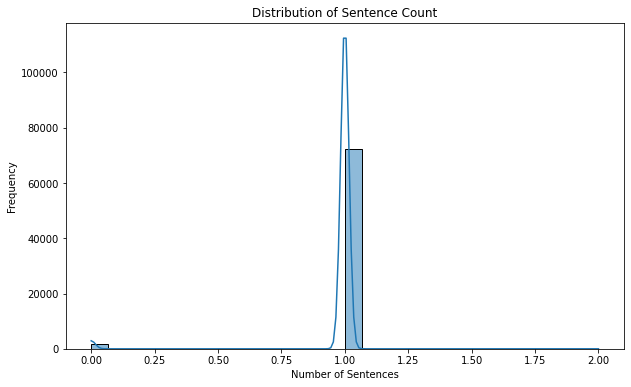

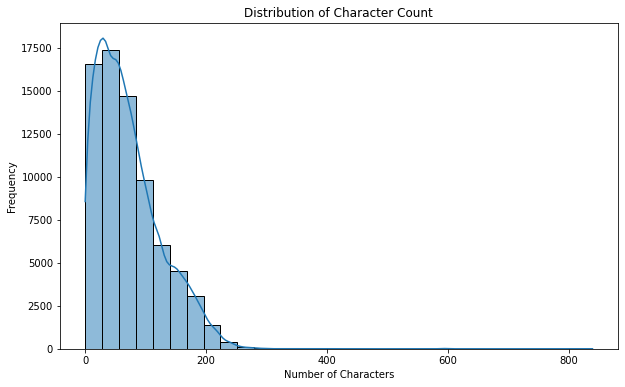

In [15]:
# Add a column for sentence count
df['sentence_count'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)) if isinstance(x, str) else 0)

# Add a column for character count
df['char_count'] = df['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Plot Sentence Count
plt.figure(figsize=(10, 6))
sns.histplot(df['sentence_count'], bins=30, kde=True)
plt.title('Distribution of Sentence Count')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.show()

# Plot Character Count
plt.figure(figsize=(10, 6))
sns.histplot(df['char_count'], bins=30, kde=True)
plt.title('Distribution of Character Count')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()